# Topic Modeling of Historical Organic Periodicals

In [1]:
from __future__ import print_function
import pickle
import subprocess
import warnings
warnings.filterwarnings("ignore")

In [2]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

In [3]:
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.decomposition import LatentDirichletAllocation, NMF

In [4]:
import pyLDAvis
import pyLDAvis.sklearn
pyLDAvis.enable_notebook()

In [5]:
from perysis import extract_topics
from perysis.load_documents import load_documents

## Learn topic models

In [6]:
# Enable if re-learning all models
num_features = 2000
num_topics = 10
if False:
    cmd = "python -m perysis.extract_topics -input_dir ../documents_processed -output_dir ../models -num_features %d -num_topics %d" % (num_features, num_topics)
    subprocess.check_call(cmd, shell=True)

## Load documents

In [7]:
documents = load_documents("../documents_processed")
periodicals = documents.groupby("Publication")

## Load document-term matrices (DTM)

In [8]:
input_dir = "../models"
# TF
dtm_file = open("%s/dtm_tf.pkl" % input_dir, "rb")
tf_vectorizer = pickle.load(dtm_file)
dtm_tf = pickle.load(dtm_file)
# TF-IDF
dtm_file = open("%s/dtm_tfidf.pkl" % input_dir, "rb")
tfidf_vectorizer = pickle.load(dtm_file)
dtm_tfidf = pickle.load(dtm_file)

## Load learned topic models

### Visualization of top words for each topic

In [9]:
def print_top_words(model, feature_names, n_top_words):
    print("Top words for each topic: \n")
    for topic_idx, topic in enumerate(model.components_):
        message = "Topic #%d: " % (topic_idx + 1)
        message += " ".join([feature_names[i]
                             for i in topic.argsort()[:-n_top_words - 1:-1]])
        print(message)
    print()

### Visualization of topics for each periodical

In [10]:
def normalize(v):
    """Normalize a non-zero vector"""
    return v / sum(v)

def print_periodicals_distribution(W):
    cols = ["Topic %d" % num for num in range(1, 1 + W.shape[1])]
    rows = periodicals.groups.keys()
    df = pd.DataFrame([], columns=cols, index=rows)
    for name, data in periodicals:
        W_for_periodical = W[data.index, :] # Document-topic matrix subset for periodical
        periodical_topic_distribution = normalize(W_for_periodical.sum(axis=0))
        df.loc[name] = periodical_topic_distribution
    ax = df.T.plot(kind="bar", fontsize=14, figsize=(20, 10))
    ax.set_title("Distribution of topics for each periodical", fontsize=24)
    ax.set_xlabel("Topic", fontsize=18)
    ax.set_ylabel("Probability", fontsize=18)
    plt.show()

### Visualization of temporal distributions for each topic

In [11]:
def print_topic_temporal_dists(T):
    rows = ["Topic %d" % num for num in range(1, 1 + W.shape[1])]
    years = documents["Year"]
    cols = range(years.min(), years.max() + 1, 1)
    df = pd.DataFrame(T, columns=cols, index=rows)
    for idx, row in df.iterrows():
        row = df.loc[idx]
        df.loc[idx] = normalize(row)
    ax = df.T.plot(kind="line", fontsize=14, figsize=(20, 10))
    ax.set_title("Temporal distribution of each topic", fontsize=24)
    ax.set_xlabel("Year", fontsize=18)
    ax.set_ylabel("Probability", fontsize=18)
    plt.show()

### Non-negative Matrix Factorization (NMF) model with Frobenius norm

In [12]:
model_file = open("%s/nmf_frobenius.pkl" % input_dir, "rb")
(model, W, T) = pickle.load(model_file)

In [13]:
# Enable to re-learn model
if False:
    model = NMF(n_components=num_topics, random_state=1, alpha=.1, l1_ratio=.3)
    W = model.fit_transform(dtm_tfidf)
    T = extract_topics.gen_topic_temporal_dists(documents, model, tf_vectorizer, dtm_tf)

Top words for each topic: 

Topic #1: gm say organic soybean corn soy crop seed company grain said testing source ingredient test ip genetically labeling bean rice eu wheat oil feed identity consumer european contamination non canola
Topic #2: milk dairy price milkweed class cheese nonfat usda cwt month cow federal butter producer cheddar dry cost january order pound consumer coop supply commodity sale industry dean powder corn nation
Topic #3: organic crop said soil farming seed agriculture research genetically sustainable natural use rice feed news plant pesticide water project study page available national conventional standard industry conference program acre consumer
Topic #4: crop gene engineered plant virus epa resistance insect genetically bacteria scientist herbicide risk cotton weed control pest field toxin agriculture biotechnology vaccine usda genetic environmental squash organism agency wild tomato
Topic #5: alfalfa gm roundup usda ready court cf judge seed impact forage b

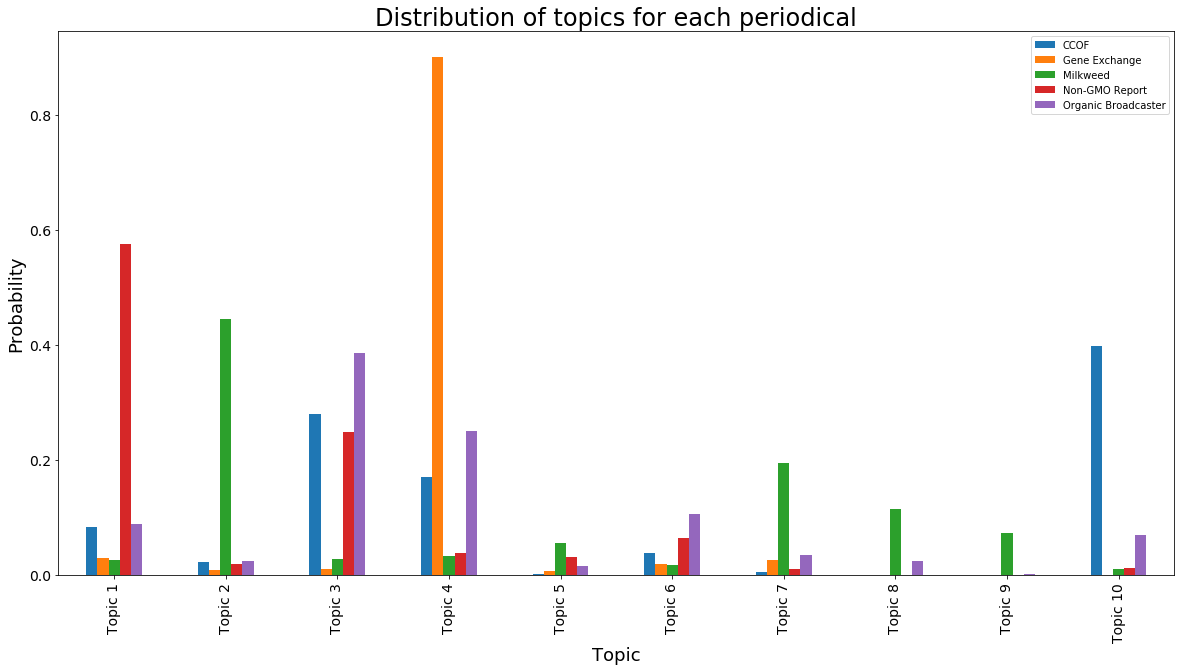

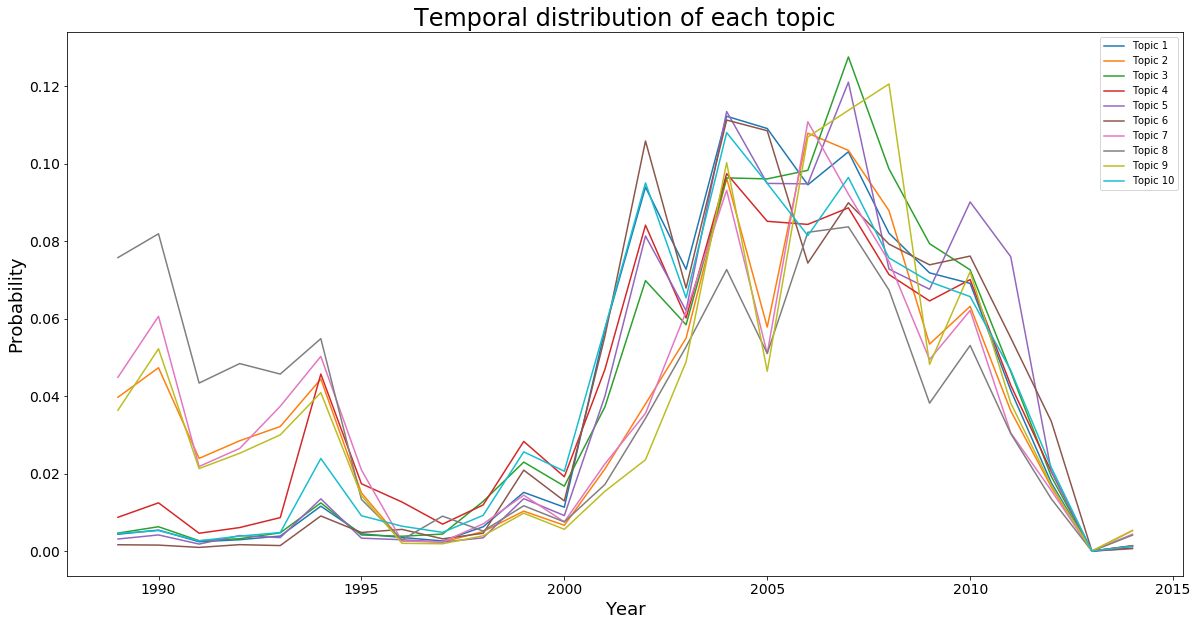

In [14]:
# print([idx for idx, _ in enumerate(model.components_) if model.components_[idx].sum() < 1e-5])
print_top_words(model, tfidf_vectorizer.get_feature_names(), 30)
print_periodicals_distribution(W)
print_topic_temporal_dists(T)
vis = pyLDAvis.sklearn.prepare(model, dtm_tfidf, tfidf_vectorizer)
pyLDAvis.display(vis)

### NMF model with Kullback-Leibler (KL) divergence

Top words for each topic: 

Topic #1: able ability address addition source national meet absence er leading area advantage service missouri minnesota information believe natural according bean ingredient approved best better based claim american lion marketing quality
Topic #2: way week milk washington milkweed change weather cheese western weekly cheddar wi family exchange fall example summer long low volume marketer month virtually madison used supply west sup nonfat set
Topic #3: farming brief organic volume spring broadcaster soil direct research plant genetically center april used way crop change page damage environmental family conventional community yield come resource pest water area agriculture
Topic #4: academy needed approved ability newsletter director organism management page office blood paper called modified according agriculture executive source end stated earlier biotechnology calling organization force document present european concern better
Topic #5: feed like net c

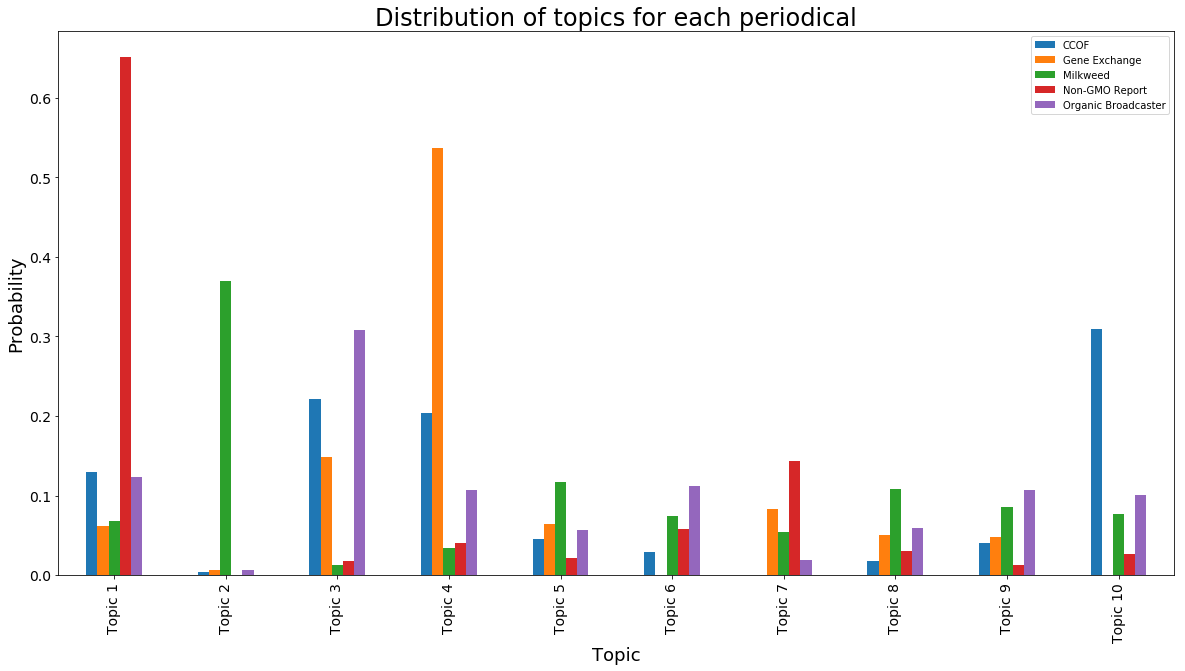

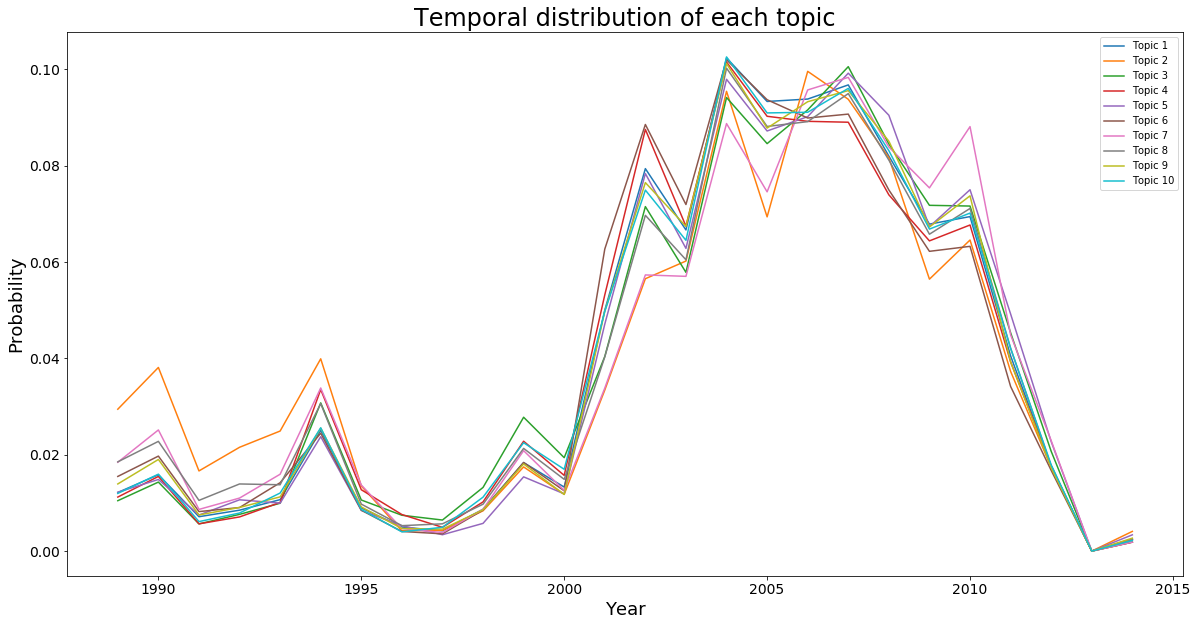

In [15]:
model_file = open("%s/nmf_kl.pkl" % input_dir, "rb")
(model, W, T) = pickle.load(model_file)
# print([idx for idx, _ in enumerate(model.components_) if model.components_[idx].sum() < 1e-5])
print_top_words(model, tfidf_vectorizer.get_feature_names(), 30)
print_periodicals_distribution(W)
print_topic_temporal_dists(T)
vis = pyLDAvis.sklearn.prepare(model, dtm_tfidf, tfidf_vectorizer)
pyLDAvis.display(vis)

### Latent Dirichlet Allocation

Top words for each topic: 

Topic #1: milk dairy fda cow cheese hormone human consumer price growth wisconsin health safety research industry animal national test sale bovine data level drug study treated public milkweed synthetic processor claim
Topic #2: milk dairy price usda cheese class cow milkweed producer cost federal month dry order pound plant supply heifer nonfat nation report sale cheddar january cwt alfalfa industry commodity million butter
Topic #3: organic seed soybean crop corn gm say grain said company soy bean email variety contact contract genetically phone demand feed supply oil ban acre growing north protein eu research specialty
Topic #4: gm organic seed corn said crop soybean grade company feed sugar genetically project alfalfa roundup beet report research usda plant natural study wheat variety source news agriculture world health group
Topic #5: cloned animal cloning clone fda grain meat consumer feed creamery testing dairy test person livestock butter pasture in

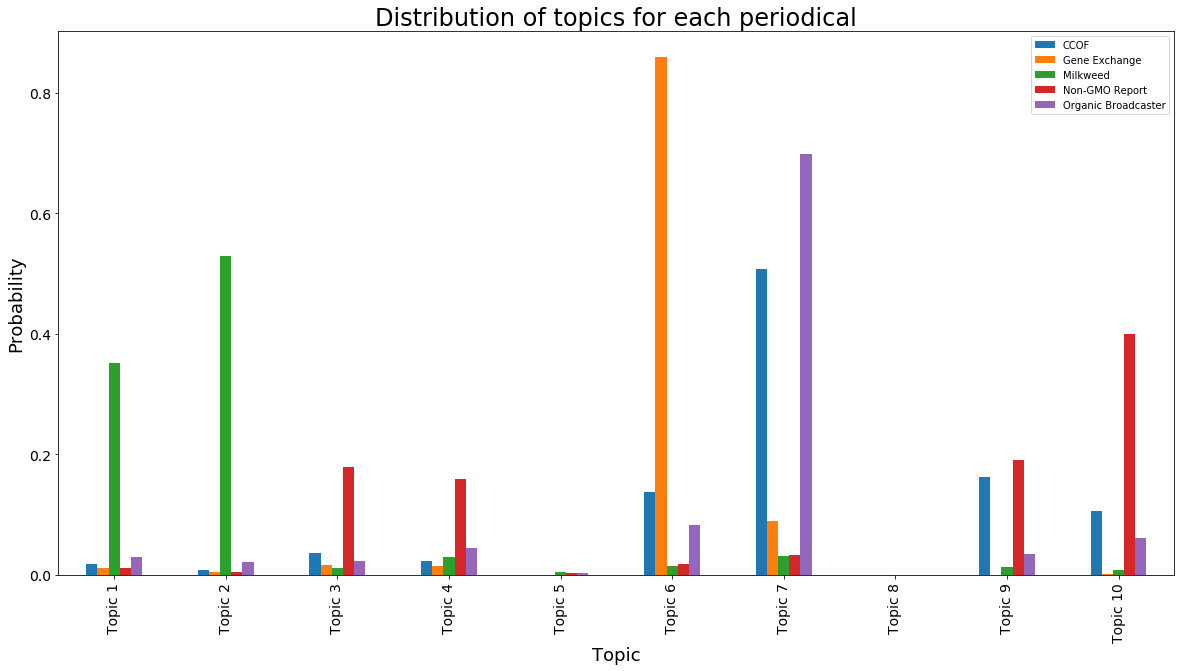

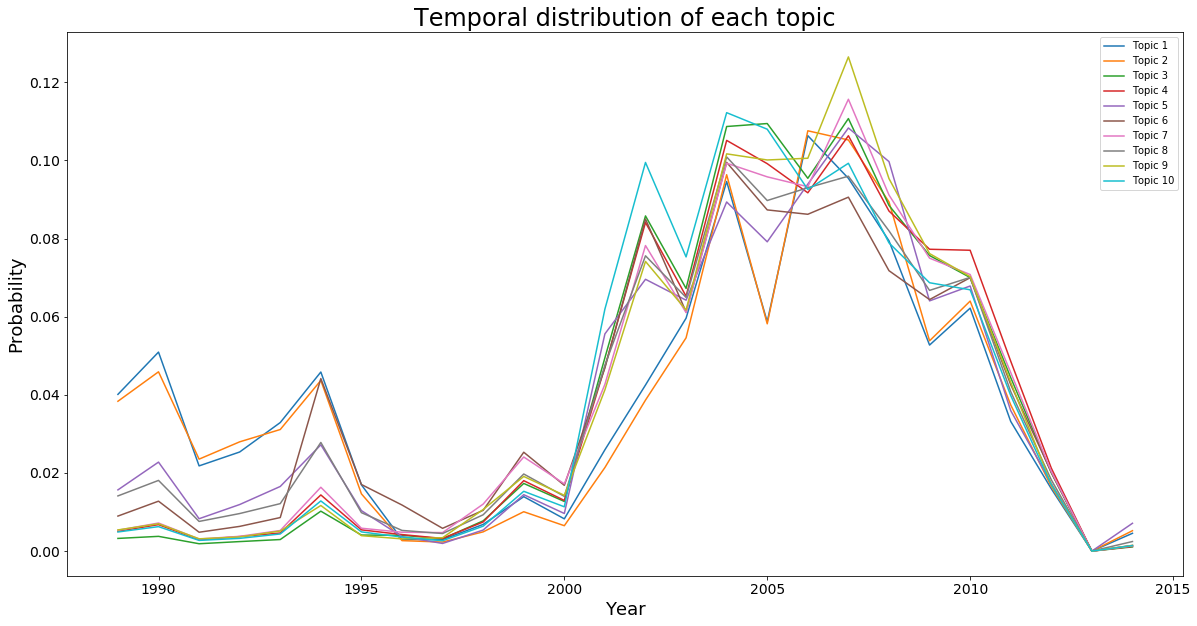

In [16]:
model_file = open("%s/lda_tf.pkl" % input_dir, "rb")
(model, W, T) = pickle.load(model_file)
print_top_words(model, tf_vectorizer.get_feature_names(), 30)
print_periodicals_distribution(W)
print_topic_temporal_dists(T)
vis = pyLDAvis.sklearn.prepare(model, dtm_tf, tf_vectorizer)
pyLDAvis.display(vis)